# Data Sources

https://www.kaggle.com/datasets/muhammadroshaanriaz/e-commerce-trends-a-guide-to-leveraging-dataset/data

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load and View data

In [3]:
df = pd.read_csv('ecommerce_product_dataset.csv')
df2 = pd.read_csv('ecommerce_product_dataset2.csv')

In [4]:
df.head()

,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-10,Albuquerque
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-28,Queens
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-20,Austin
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-05,Dallas
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-10,Tucson


In [5]:
df2.head()

,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,City,Stock In Vast or Limited Quantity
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,11/10/2023,Albuquerque,True
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,9/28/2023,Queens,True
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,10/20/2023,Austin,True
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,12/5/2023,Dallas,True
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,8/10/2023,Tucson,True


# Preprocess Data

In [6]:
# Create a new feature combining 'NumReviews' and 'Rating'
df['ReviewScore'] = df['NumReviews'] * df['Rating']

# Update columns for clustering to include the new feature and remove 'NumReviews' and 'Rating'
columns_for_clustering = ['Price', 'ReviewScore', 'StockQuantity', 'Discount', 'Sales']

# Define Preprocessing Function
def preprocess_data(df):
    # Select relevant columns
    data = df[columns_for_clustering]

    # Handle missing values
    data = data.fillna(data.mean())

    # Scale the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, df

# Preprocess the data again
scaled_data, original_data = preprocess_data(df)
scaled_data

# Apply log transformation to the 'Sales' column
df['LogSales'] = np.log1p(df['Sales'])  # log(1 + Sales)

# Update columns for clustering to use 'LogSales' instead of 'Sales'
columns_for_clustering = ['Price', 'ReviewScore', 'StockQuantity', 'Discount', 'LogSales']

# Preprocess the data again
scaled_data, original_data = preprocess_data(df)


A new feature ReviewScore is created to combine NumReviews and Rating for better clustering.

On the preprocessing section we had done the: 
- Handling missing values
- Standardizing numerical features
- Applying log transformation to Sales

# Elbow Method

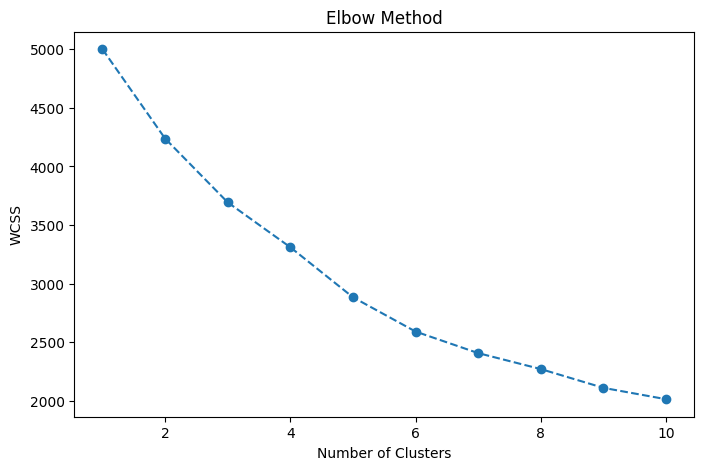

In [7]:
# Elbow Method function
def find_optimal_clusters(data, max_k=10):
    wcss = []  # Within-cluster sum of squares
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    # Plot the Elbow graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

    return wcss

# Run the Elbow Method
wcss = find_optimal_clusters(scaled_data, max_k=10)

Next, to do the K-mean clustering we need to find the opitmal cluster.
The Elbow Method helps determine the best k value for clustering.
Based on the elbow method graph above, the optimal cluster can be determine 

# Determine Optimal Clusters

From the graph above we can saw that the optimal cluster is 3

In [8]:
# Perform K-Means with the chosen number of clusters
optimal_k = 3

# Modeling

## K-Means Clustering

In [9]:
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the original data
original_data['KMeans_Cluster'] = kmeans.labels_

In [10]:
# Evaluate K-Means clustering using silhouette score
kmeans_silhouette = silhouette_score(scaled_data, kmeans.labels_)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.2f}")

K-Means Silhouette Score: 0.16


K-Means groups products into clusters based on similarity. The Elbow Method helps determine the best number of clusters (k). The algorithm assigns each product to a cluster, updates cluster centers, and repeats until stable. We store these cluster labels in the dataset (KMeans_Cluster) and measure the Silhouette Score to check how well the clustering works.

## Agglomerative Clustering

In [11]:
# Perform Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agglo_labels = agglo.fit_predict(scaled_data)

# Add Agglomerative cluster labels to the original dataframe
original_data['Agglo_Cluster'] = agglo_labels

In [12]:
# Evaluate Agglomerative clustering using silhouette score
agglo_silhouette = silhouette_score(scaled_data, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.2f}")

Agglomerative Clustering Silhouette Score: 0.10


Agglomerative Clustering is a hierarchical method that starts with each product as its own cluster and merges them step by step. We set the same number of clusters as K-Means, apply Ward’s linkage (which minimizes cluster variance), and save the results in Agglo_Cluster. The Silhouette Score helps evaluate cluster quality.

## PCA Reduction Function

In [13]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Print explained variance ratio
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

Explained variance ratio by PCA components: [0.21362764 0.20454258]


Since clustering is harder with many features, PCA (Principal Component Analysis) reduces data to two dimensions while keeping important patterns. This helps make clustering faster and easier to visualize. We check the explained variance to confirm PCA retains enough information.

## K-Means Clustering on PCA-Reduced Data

In [14]:
# Perform K-Means Clustering on PCA-reduced data
kmeans_pca = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans_pca.fit(pca_data)

# Add cluster labels to the original data
original_data['PCA_KMeans_Cluster'] = kmeans_pca.labels_

# Evaluate K-Means on PCA data
kmeans_pca_silhouette = silhouette_score(pca_data, kmeans_pca.labels_)
print(f"K-Means Silhouette Score on PCA Data: {kmeans_pca_silhouette:.2f}")

K-Means Silhouette Score on PCA Data: 0.34


After reducing the dataset, we rerun K-Means and Agglomerative Clustering on the PCA-transformed data. The clusters are now in a 2D space, making them easier to understand. The new cluster labels are stored as PCA_KMeans_Cluster and PCA_Agglo_Cluster, and we again calculate the Silhouette Score to measure accuracy.

## Agglomerative Clustering on PCA-Reduced Data

In [15]:
# Perform Agglomerative Clustering on PCA-reduced data
agglo_pca = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agglo_pca_labels = agglo_pca.fit_predict(pca_data)

# Add Agglomerative cluster labels to the original dataframe
original_data['PCA_Agglo_Cluster'] = agglo_pca_labels

# Evaluate Agglomerative Clustering on PCA data
agglo_pca_silhouette = silhouette_score(pca_data, agglo_pca_labels)
print(f"Agglomerative Clustering Silhouette Score on PCA Data: {agglo_pca_silhouette:.2f}")

Agglomerative Clustering Silhouette Score on PCA Data: 0.30


### Clustering Results Comparison

| Clustering Method                  | Silhouette Score |
|------------------------------------|------------------|
| K-Means (Original Data)            | 0.16          |
| Agglomerative Clustering (Original Data) | 0.10       |
| K-Means (PCA-Reduced Data)         | 0.34             |
| Agglomerative Clustering (PCA-Reduced Data) | 0.30    |


# Visualization 

In [16]:
# Visualization of Clusters
def visualize_pca_clusters(pca_data, labels, title):
    plt.figure(figsize=(10, 6))
    for cluster in np.unique(labels):
        plt.scatter(
            pca_data[labels == cluster, 0],
            pca_data[labels == cluster, 1],
            label=f'Cluster {cluster}'
        )
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

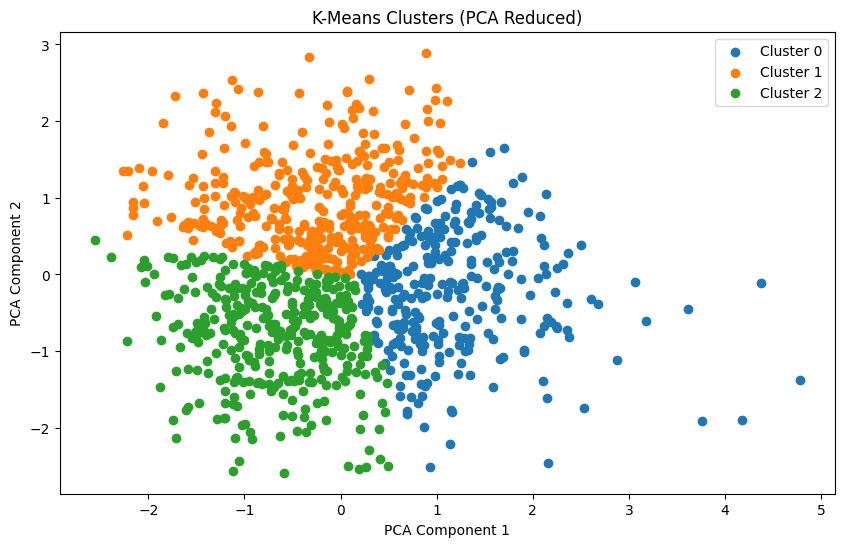

In [17]:
# Visualize K-Means Clusters
visualize_pca_clusters(pca_data, kmeans_pca.labels_, "K-Means Clusters (PCA Reduced)")

# Analyze Clusters

In [18]:
# Analyze clusters and compute summary statistics
def analyze_clusters(df, cluster_column):
    numeric_columns = df.select_dtypes(include=np.number).columns
    cluster_summary = df.groupby(cluster_column)[numeric_columns].mean()
    return cluster_summary

# Cluster-wise summary for K-Means
kmeans_summary = analyze_clusters(original_data, 'KMeans_Cluster')
print("K-Means Cluster Summary:")
display(kmeans_summary)

K-Means Cluster Summary:


,ProductID,Price,Rating,NumReviews,StockQuantity,Discount,Sales,ReviewScore,LogSales,KMeans_Cluster,Agglo_Cluster,PCA_KMeans_Cluster,PCA_Agglo_Cluster
KMeans_Cluster,,,,,,,,,,,,,
0,489.047493,288.755172,2.693140,2038.562005,519.807388,0.123668,985.902375,5010.507388,6.610529,0.0,0.952507,1.525066,1.234828
1,510.339844,246.449688,3.905859,3949.968750,440.886719,0.251797,1040.753906,15193.045313,6.634030,1.0,0.914062,1.003906,0.148438
2,505.490411,222.592274,2.753425,1958.756164,508.276712,0.384411,1016.293151,4808.991507,6.591838,2.0,0.852055,0.630137,0.638356


# K-Means clustering on PCA-reduced data

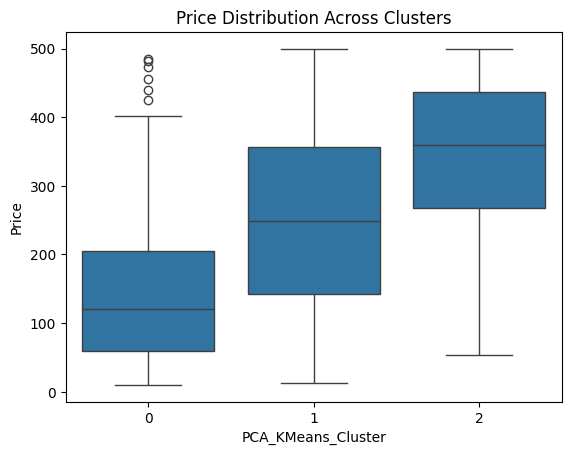

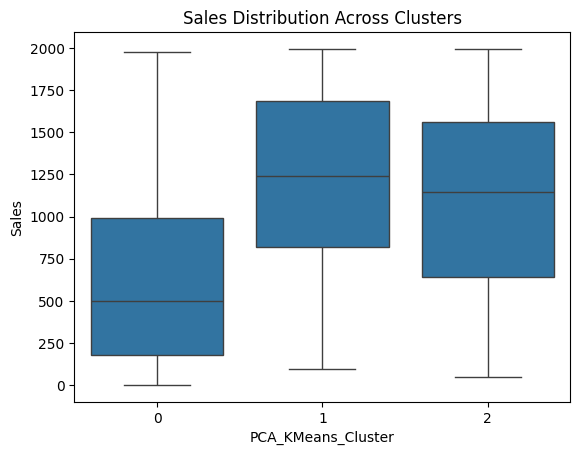

In [31]:
import seaborn as sns

# Example: Distribution of prices across clusters
sns.boxplot(x='PCA_KMeans_Cluster', y='Price', data=original_data)
plt.title('Price Distribution Across Clusters')
plt.show()

# Example: Sales across clusters
sns.boxplot(x='PCA_KMeans_Cluster', y='Sales', data=original_data)
plt.title('Sales Distribution Across Clusters')
plt.show()

### **Price Distribution Across Clusters**
- **Cluster 0**: Represents budget-friendly products with low to moderate prices. This category likely appeals to price-sensitive customers or essential items.
- **Cluster 1**: Comprises mid-range products with a wide price distribution, indicating a mix of standard and premium offerings.
- **Cluster 2**: Contains high-priced products, suggesting luxury or exclusive items aimed at high-spending customers.

### **Sales Distribution Across Clusters**
- **Cluster 0**: Shows moderate sales but with a wide spread, meaning these products have diverse demand levels.
- **Cluster 1**: Has the highest sales, indicating strong market demand for products in this category.
- **Cluster 2**: Similar to Cluster 1 but with slightly lower sales, suggesting premium products with steady demand.



### **Business Insights**
This clustering highlights distinct product segments:
- **Clusters 1 and 2** have strong sales, so the business could focus on maintaining or expanding premium offerings.
- **Cluster 0** includes budget-friendly products with varying sales, so introducing promotions or bundling strategies might improve performance.
- The **wide sales range in Cluster 0** suggests that some budget products are highly popular, while others may require better positioning.